In [1]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

from transformers import BertConfig
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

from models import BertForDiffusion, DiffusionLMFixedEmb
from data_utils import load_e2enlg_dataset_and_tokenizer, E2enlgDataset, load_rocstories_dataset_and_tokenizer, RocstoriesDataset
from noise_schedule import get_named_beta_schedule
from train_utils import train, evaluate

%matplotlib inline

In [2]:
bert_config = BertConfig.from_pretrained("bert-base-uncased")
print(bert_config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [2]:
# dataset args
max_len = 72    # maximum length of input_ids
vocab_threshold = 10    # occurrence time < threshold token as [UNK]
test_size = 0.1     # size of evaluation dataset

# training args
batch_size = 64
device = torch.device("cuda:1")
lr = 2e-4
num_epoch = 50
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 16
# hidden_size = 768
# num_hidden_layers = 12
# num_attention_heads = 12
# intermediate_size = 3072
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

In [3]:
tokenized_rocstories_dataset, tokenizer = load_rocstories_dataset_and_tokenizer(max_len=max_len, vocab_threshold=vocab_threshold)

rev_tokenizer = {v: k for k, v in tokenizer.items()}

train_set, eval_set = train_test_split(tokenized_rocstories_dataset, test_size=test_size, shuffle=True)

train_dataset = RocstoriesDataset(data_lst=train_set['input_ids'], attention_mask_lst=train_set['attention_mask'])
print("Training set size:",len(train_dataset))
eval_dataset = RocstoriesDataset(data_lst=eval_set['input_ids'], attention_mask_lst=eval_set['attention_mask'])
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

No config specified, defaulting to: roc_stories/all
Reusing dataset roc_stories (/home/dingyizhou/.cache/huggingface/datasets/wza___roc_stories/all/2.1.0/43e2851d9f31e08e4b2dd07a8057ed7a64cbb25cc7105d09856c14e638695506)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98161 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?ba/s]

Training set size: 88344
Evaluation set size: 9817


In [4]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
config.word_embedding_dim = word_embedding_dim

print(config)

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 72,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11831,
  "word_embedding_dim": 16
}



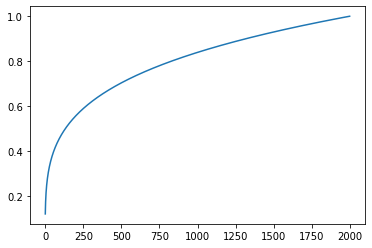

In [5]:
betas = torch.Tensor(get_named_beta_schedule(schedule_name="sqrt", num_diffusion_timesteps=config.T))
# betas = torch.Tensor(get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=config.T))

alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
plt.plot(sqrt_one_minus_alphas_bar)

In [6]:
diffusion_model = DiffusionLMFixedEmb(config=config, betas=betas, emb_type='randn', self_condition=True, add_emb_noise=False).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

using randn word embedding
Diffusion model #parameters:
13789712


In [7]:
diffusion_model

DiffusionLMFixedEmb(
  (model): BertForDiffusion(
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=512, out_features=2048, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
        

In [ ]:
loss_terms_dict_lst = []
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    loss_terms_dict_lst.append(train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar ,verbose=True))
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader)

In [9]:
loss_terms_dict = {'mse':[]}
for ep in range(num_epoch):
    loss_terms_dict['mse'] += loss_terms_dict_lst[ep]['mse']

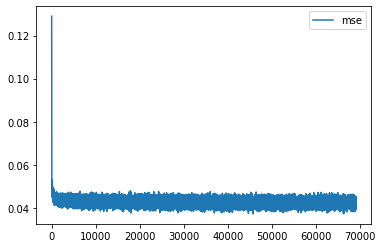

In [10]:
plt.plot(loss_terms_dict['mse'], label='mse')
plt.legend()
# plt.yscale('log')

In [11]:
x_T = torch.randn(size=(batch_size, max_len, word_embedding_dim))

In [12]:
x_0, hidden_states = diffusion_model.sample(x_T.to(device), return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
sample_idx = 0
for step in [0,1000,1500,1800,1900,1950,1990,1995,1998,1999]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        sampled_ids = diffusion_model.rounding(hidden_state).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

step: 0
calorie diagnosis technician argued honeymoon IRS fled hesitation Eugene seen intended costume respected graciously guessing favors Wilma Pepper setup Leah goodbyes Feeling pork higher cider man hearts pity any sleeping stockings redo rearranged Garth alot As below positions height Otis piggy Bill cravings stung cops surroundings somehow Leah shiny owned studio Melody Ella production toasted packets followers persisted involving flooding spiked authority n't chocolate 2000 yards waitress Pepper temptation remained trophy Cass
step: 1000
write step World admitted Bert jogged Las brown across tours Bethany Irish angry Instantly lady broadcast topping attempted demolished minding Brenda sure generosity puck laughs worm Its beam thousand halfway mischievous grandchild Trina connect loop granddaughter tool instead former Jay sobbed detail absence usually consume Jan. red cozy fiance swung pan sea motion Elaine roles passionate movements policy example voted spice choir sides kindnes

In [15]:
for sample_idx in range(batch_size):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        sampled_ids = diffusion_model.rounding(hidden_state).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] products went to a new definition to school . She had a Jeffrey for day . The day took her him . They decided a dire for arrow . awful was physics to take the enough . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] awful was never forgiving . She was out to work the hopeless . She did n't regular got try and would lots poetry . She tried to see some again . She did n't up clawed how be a admitted like . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] I went to the that I my my petition tropical . We decided out on new home . It able to him to the renewed . I started to night . I could n't up to rush out . We told a [UNK] [UNK] the Some . [END]

In [17]:
for n,p in diffusion_model.named_parameters():
    print(n)

model.encoder.layer.0.attention.self.query.weight
model.encoder.layer.0.attention.self.query.bias
model.encoder.layer.0.attention.self.key.weight
model.encoder.layer.0.attention.self.key.bias
model.encoder.layer.0.attention.self.value.weight
model.encoder.layer.0.attention.self.value.bias
model.encoder.layer.0.attention.output.dense.weight
model.encoder.layer.0.attention.output.dense.bias
model.encoder.layer.0.attention.output.LayerNorm.weight
model.encoder.layer.0.attention.output.LayerNorm.bias
model.encoder.layer.0.intermediate.dense.weight
model.encoder.layer.0.intermediate.dense.bias
model.encoder.layer.0.output.dense.weight
model.encoder.layer.0.output.dense.bias
model.encoder.layer.0.output.LayerNorm.weight
model.encoder.layer.0.output.LayerNorm.bias
model.encoder.layer.1.attention.self.query.weight
model.encoder.layer.1.attention.self.query.bias
model.encoder.layer.1.attention.self.key.weight
model.encoder.layer.1.attention.self.key.bias
model.encoder.layer.1.attention.self.val